# R kernel

In [4]:
suppressMessages({
library(ggplot2)
library(dplyr)
library(tidyr)
library(ggpubr)
library(cowplot)
library(gridExtra)
library(rstatix)
library(reshape2)
library(ggnewscale)
library(RColorBrewer)
})

In [7]:
gene_expr = read.csv("../Figure2/Epi_depth_bin_gene_exp.csv",head=T, row.names=1)

In [8]:
genes = c('IL36RN', "IL18", "IL1RN",'CXCL9',"CXCL11","CXCL14",'IFI44L','IFITM1')

In [13]:
plots = list()
for (i in 1:length(genes))
{
    stat.test.lst <- list()
    com_group.lst <- list()
    
    com_group.lst[[1]] <- c('HC', 'DLE')
    com_group.lst[[2]] <- c('HC', 'SLE')

    gene_expr_sub = subset(gene_expr, gene == genes[i])
    
    for (com_group in com_group.lst){
        prefix = paste(com_group, collapse = '_vs_')

        gene_expr_sub_test <- gene_expr_sub[gene_expr_sub$group %in% com_group,]
        stat.test.lst[[prefix]] <- gene_expr_sub_test %>% group_by(Depth_bin) %>% wilcox_test(expression ~ group, p.adjust.method = "none") %>% add_xy_position(x='Depth_bin')
        stat.test.lst[[prefix]]$p.signif = ifelse(stat.test.lst[[prefix]]$p <0.0001, '****',
                                    ifelse(stat.test.lst[[prefix]]$p <0.001 & stat.test.lst[[prefix]]$p > 0.0001, '***',
                                    ifelse(stat.test.lst[[prefix]]$p <0.01 & stat.test.lst[[prefix]]$p > 0.001, '**', 
                                    ifelse(stat.test.lst[[prefix]]$p <0.05 & stat.test.lst[[prefix]]$p > 0.01, '*','ns'
                                    ))))
    }

    mean_sd <- gene_expr_sub %>%
            group_by(group, Depth_bin, gene) %>%
            summarize(mean_expr = mean(expression), 
            se_expr = sd(expression) / sqrt(n()),
            sum = mean_expr + se_expr)
                      
    stat.test.lst[[1]] <- stat.test.lst[[1]] %>% mutate(y.position = max(mean_sd$sum) + 0.1*max(mean_sd$sum))
    stat.test.lst[[2]] <- stat.test.lst[[2]] %>% mutate(y.position = max(mean_sd$sum) + 0.2*max(mean_sd$sum))
 
    plots[[i]] <- ggline(gene_expr_sub, x="Depth_bin", y="expression", add=c("mean_se"),  error.plot = "errorbar", 
                add.params = list(size = 1, width = 0.3),color = "group", palette = group_color, shape=20, stroke=NA, size=0.25,
                point.size = 0.1, nrow=1) + 
    stat_pvalue_manual(stat.test.lst[['HC_vs_DLE']], label = "p.signif", linetype  = "blank", hide.ns = TRUE, hjust=0.5, vjust = 1, color = '#019167',label.size=2.5) + 
    stat_pvalue_manual(stat.test.lst[['HC_vs_SLE']], label = "p.signif", linetype  = "blank", hide.ns = TRUE, hjust=0.5, vjust = 1, color = '#0166aa',label.size=2.5) + 
    ggtitle(genes[i]) +
    labs(y='Expression Levels', x='Epi depth') +
    mytheme() +
        theme(axis.text.x=element_text(size=6,color="black",angle=90,hjust=1,vjust=0.5),
        axis.text.y=element_text(size=6,color="black"),
        axis.title=element_text(size=6,color="black"),
        plot.title=element_text(size=6,color="black"),
        strip.background=element_rect(linewidth=0.25, color='black', fill="white"),
        panel.spacing = unit(0.15, "cm"),
        legend.position = "none"
    )
}

`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'group', 'Depth_bin'. You can override
using the `.groups` argument.


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's fill values.”


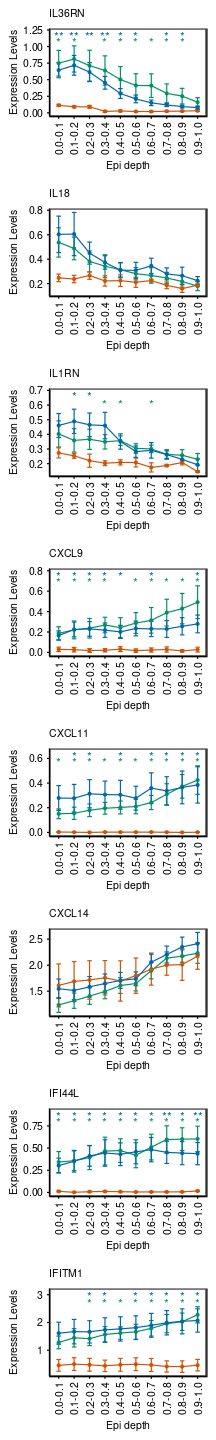

In [14]:
options(repr.plot.width =1.8,repr.plot.height = 12)
do.call(plot_grid,c(plots,ncol=1,align='v'))

# pdf("figures/Cellbin_Epi_depth_cytokine_expression_1.pdf",w=1.3,h=8)
# do.call(plot_grid,c(plots,ncol=1,align='v'))
# dev.off()

# Python kernel

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
from shapely.geometry import GeometryCollection, Polygon
import matplotlib.backends.backend_pdf as pdf_backend
import warnings
warnings.filterwarnings('ignore')
import importlib

import utils_20250718
importlib.reload(utils_20250718)
from utils_20250718 import *

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
ST_adata = sc.read_h5ad('/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Cellbin_h5ad_raw/All_samples_Cellbin_filter_gene200_add_anno_dist.h5ad')
sc.pp.normalize_total(ST_adata, target_sum=10000)
sc.pp.log1p(ST_adata)

In [3]:
genes_plot = ['IL36RN', "IL18", "IL1RN",'CXCL9',"CXCL11","CXCL14",'IFI44L','IFITM1']
samples = ["HC2","DLE4","SLE2"]

In [4]:
polygons = {
    "HC2_IL36RN": [Polygon([[8300, 19400], [9300, 19400], [9300, 18400], [8300, 18400]])],
    "HC2_IL18" : [Polygon([[10000, 19500], [11000, 19500], [11000, 18500], [10000, 18500]])],
    "HC2_IL1RN": [Polygon([[8300, 19400], [9300, 19400], [9300, 18400], [8300, 18400]])],
    "HC2_CXCL9" : [Polygon([[10000, 19500], [11000, 19500], [11000, 18500], [10000, 18500]])],
    "HC2_CXCL11": [Polygon([[8300, 19400], [9300, 19400], [9300, 18400], [8300, 18400]])],
    "HC2_CXCL14": [Polygon([[8300, 19400], [9300, 19400], [9300, 18400], [8300, 18400]])],
    "HC2_IFI44L" : [Polygon([[10000, 19500], [11000, 19500], [11000, 18500], [10000, 18500]])],
    "HC2_IFITM1": [Polygon([[8300, 19400], [9300, 19400], [9300, 18400], [8300, 18400]])],

    'DLE4_IL36RN' :[Polygon([[11500, 16800], [12500, 16800], [12500, 15800], [11500, 15800]])],
    'DLE4_IL18' :[Polygon([[18000, 17200], [19000, 17200], [19000, 16200], [18000, 16200]])],
    'DLE4_IL1RN' :[Polygon([[10200,16850], [11200,16850],[11200,15850], [10200,15850]])],
    'DLE4_CXCL9' :[Polygon([[12000,16900], [13000,16900],[13000,15900], [12000,15900]])],
    'DLE4_CXCL11' :[Polygon([[12000,16900], [13000,16900],[13000,15900], [12000,15900]])],
    'DLE4_CXCL14' :[Polygon([[7300,17400], [8300,17400],[8300,16400], [7300,16400]])],    
    'DLE4_IFI44L' :[Polygon([[17000, 17300], [18000, 17300], [18000, 16300], [17000, 16300]])],
    'DLE4_IFITM1' :[Polygon([[17000, 17300], [18000, 17300], [18000, 16300], [17000, 16300]])],

    "SLE2_IL36RN": [Polygon([[12100, 18500], [13100, 18500], [13100, 17500], [12100, 17500]])],
    "SLE2_IL18": [Polygon([[18200,17900], [19200,17900],[19200,16900], [18200,16900]])],
    "SLE2_IL1RN": [Polygon([[11600, 18500], [12600, 18500], [12600, 17500], [11600, 17500]])],
    "SLE2_CXCL9": [Polygon([[11600, 18500], [12600, 18500], [12600, 17500], [11600, 17500]])],    
    "SLE2_CXCL11": [Polygon([[16200,18100], [17200,18100],[17200,17100], [16200,17100]])],
    "SLE2_CXCL14": [Polygon([[11600, 18500], [12600, 18500], [12600, 17500], [11600, 17500]])],   
    "SLE2_IFI44L": [Polygon([[11600, 18500], [12600, 18500], [12600, 17500], [11600, 17500]])],
    "SLE2_IFITM1": [Polygon([[11600, 18500], [12600, 18500], [12600, 17500], [11600, 17500]])]   
}

[22:05:36] ❕  ssat is not registered, register now                                           ]8;id=817095;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=828644;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:05:37] ❕  ssat is not registered, register now                                           ]8;id=471891;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=617467;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:05:40] ❕  ssat is not registered, register now                                           ]8;id=307738;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=212746;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:05:44] ❕  ssat is not registered, register now                                           ]8;id=162251;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=236430;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:05:45] ❕  ssat is not registered, register now                                           ]8;id=181807;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=663756;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:05:48] ❕  ssat is not registered, register now                                           ]8;id=674641;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=394654;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:05:52] ❕  ssat is not registered, register now                                           ]8;id=120478;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=378064;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:05:54] ❕  ssat is not registered, register now                                           ]8;id=774848;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=392863;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:05:57] ❕  ssat is not registered, register now                                           ]8;id=451539;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=488087;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:01] ❕  ssat is not registered, register now                                           ]8;id=790696;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=236262;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:03] ❕  ssat is not registered, register now                                           ]8;id=473339;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=641138;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:07] ❕  ssat is not registered, register now                                           ]8;id=123959;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=757129;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:11] ❕  ssat is not registered, register now                                           ]8;id=410740;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=798766;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:14] ❕  ssat is not registered, register now                                           ]8;id=616302;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=572786;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:18] ❕  ssat is not registered, register now                                           ]8;id=600123;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=148531;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:22] ❕  ssat is not registered, register now                                           ]8;id=798835;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=828591;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:25] ❕  ssat is not registered, register now                                           ]8;id=530055;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=249574;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:30] ❕  ssat is not registered, register now                                           ]8;id=371444;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=865097;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:34] ❕  ssat is not registered, register now                                           ]8;id=926877;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=114684;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:38] ❕  ssat is not registered, register now                                           ]8;id=424930;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=268433;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:42] ❕  ssat is not registered, register now                                           ]8;id=255340;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=382085;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:47] ❕  ssat is not registered, register now                                           ]8;id=510481;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=32685;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:51] ❕  ssat is not registered, register now                                           ]8;id=149764;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=159666;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[22:06:56] ❕  ssat is not registered, register now                                           ]8;id=163729;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=298477;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

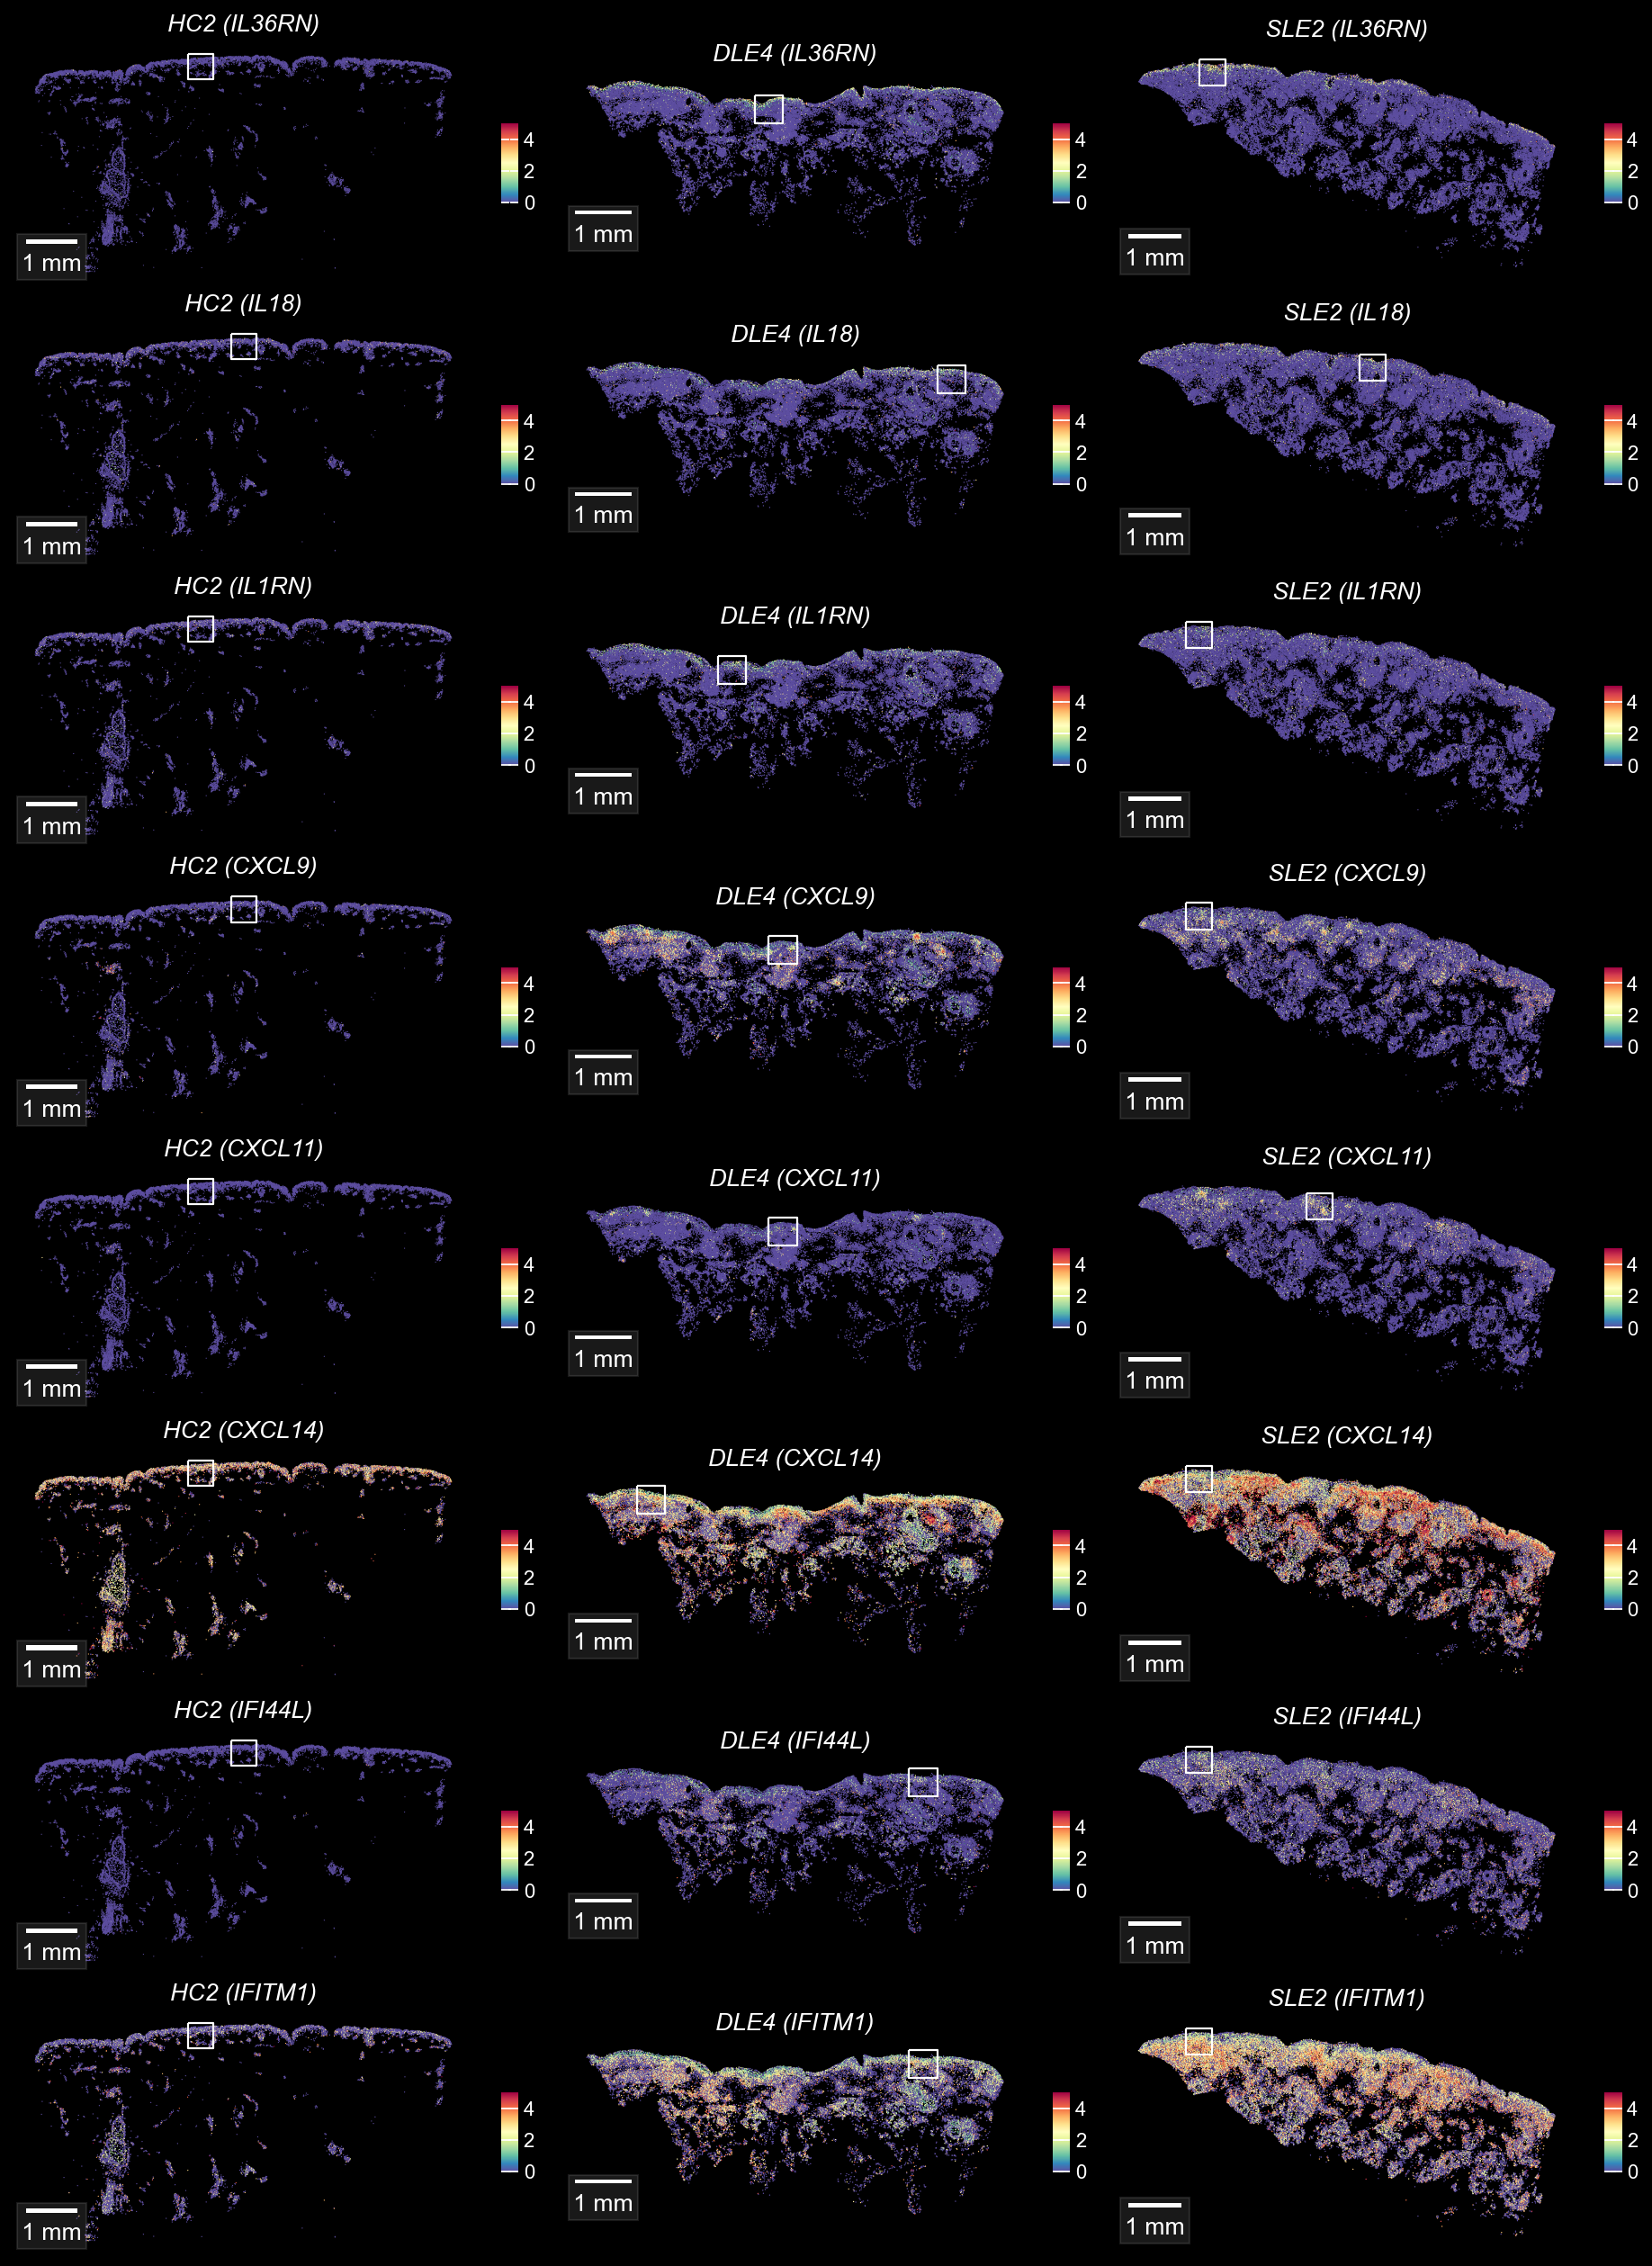

In [9]:
n_genes = len(genes_plot)
n_samples = len(samples)

with mpl.style.context('dark_background'):
    fig, axs = plt.subplots(
        nrows=n_genes,
        ncols=n_samples,
        figsize=(4 * n_samples, 2 * n_genes),
        squeeze=False
    )
    
    for i, gene in enumerate(genes_plot):   
        for j, sample in enumerate(samples):    
            ax = axs[i, j]
            
            polygon_key = f"{sample}_{gene}" 
            polygon = polygons.get(polygon_key)
            sample_adata = ST_adata[ST_adata.obs["sample"] == sample]
            ax = featureplot(sample_adata,features=gene,reduction="spatial", ax=ax, dot_size=100, style="dark_background", vmax=5) #
            draw_scalebar(ax=ax, color='white', location='lower left')
            gpd.GeoSeries(polygon).plot(ax=ax, edgecolor='white',facecolor='none', linewidth=1)
            ax.set_title(f"{sample} ({gene})", fontsize=12)  

    # plt.tight_layout(pad=1.0)
    # plt.show()
#save_fig(f"../../figures/Cellbin_KC_cytokine_gene_spatial_whole_other")

In [37]:
zones = {
    'HC2_IL36RN' : [8300,18400,9300,19400], # IL36RN, CXCL11,CXCL14,IL1RN,IFITM1
    'HC2_IL18' : [10000,18500,11000,19500],# IL18, CXCL9, IFI44L
    'HC2_IL1RN' : [8300,18400,9300,19400],
    'HC2_CXCL9' : [10000,18500,11000,19500],
    'HC2_CXCL11' : [8300,18400,9300,19400],
    'HC2_CXCL14' : [8300,18400,9300,19400],
    'HC2_IFI44L' : [10000,18500,11000,19500],
    'HC2_IFITM1' : [8300,18400,9300,19400],
    
    'DLE4_IL36RN' : [11500,15800,12500,16800], # IL36RN
    'DLE4_IL18' : [18000,16200,19000,17200], # IL18
    'DLE4_IL1RN' : [10200,15850,11200,16850],# IL1RN
    'DLE4_CXCL9' :[12000,15900,13000,16900], # CXCL9,CXCL11
    'DLE4_CXCL11' :[12000,15900,13000,16900],
    'DLE4_CXCL14' :[7300,16400,8300,17400], # CXCL14
    'DLE4_IFI44L' :[17000,16300,18000,17300], # IFI44L,IFITM1
    'DLE4_IFITM1' :[17000,16300,18000,17300],
    
    'SLE2_IL36RN' : [12000,17500,13000,18500], # IL36RN
    'SLE2_IL18' : [18200,16900,19200,17900], # IL18 
    'SLE2_IL1RN' : [11600,17500,12600,18500], # IL1RN,IFI44L,CXCL14,CXCL9,IFITM1
    'SLE2_CXCL9' : [11600,17500,12600,18500],
    'SLE2_CXCL11' : [16200,17100,17200,18100],  # CXCL11
    'SLE2_CXCL14' : [11600,17500,12600,18500],
    'SLE2_IFI44L' : [11600,17500,12600,18500],
    'SLE2_IFITM1': [11600,17500,12600,18500]
}

[15:39:27] 📃  Filtering contour within bounding box [8300, 18400, 9300, 19400]              ]8;id=529090;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=542731;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=621191;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=758171;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:30] 📃  Filtering contour within bounding box [11500, 15800, 12500, 16800]            ]8;id=164677;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=853423;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=16937;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=735487;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:32] 📃  Filtering contour within bounding box [12000, 17500, 13000, 18500]            ]8;id=436441;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=477824;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=744237;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=357416;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:34] 📃  Filtering contour within bounding box [10000, 18500, 11000, 19500]            ]8;id=338129;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=921472;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=741714;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=778474;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:37] 📃  Filtering contour within bounding box [18000, 16200, 19000, 17200]            ]8;id=343141;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=225576;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=923461;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=951202;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:39] 📃  Filtering contour within bounding box [18200, 16900, 19200, 17900]            ]8;id=325261;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=350255;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

[15:39:40] ❕  ssat is not registered, register now                                           ]8;id=116433;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=599644;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:42] 📃  Filtering contour within bounding box [8300, 18400, 9300, 19400]              ]8;id=451732;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=913117;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=706727;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=257929;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:44] 📃  Filtering contour within bounding box [10200, 15850, 11200, 16850]            ]8;id=373497;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=598945;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=477261;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=480211;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:46] 📃  Filtering contour within bounding box [11600, 17500, 12600, 18500]            ]8;id=915442;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=125012;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=359796;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=127118;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:48] 📃  Filtering contour within bounding box [10000, 18500, 11000, 19500]            ]8;id=406670;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=614626;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=672010;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=455601;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:51] 📃  Filtering contour within bounding box [12000, 15900, 13000, 16900]            ]8;id=491252;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=194089;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=965370;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=511763;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:53] 📃  Filtering contour within bounding box [11600, 17500, 12600, 18500]            ]8;id=339651;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=777654;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

[15:39:54] ❕  ssat is not registered, register now                                           ]8;id=357798;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=426432;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:56] 📃  Filtering contour within bounding box [8300, 18400, 9300, 19400]              ]8;id=166004;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=919374;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=901618;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=937811;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:39:58] 📃  Filtering contour within bounding box [12000, 15900, 13000, 16900]            ]8;id=756494;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=180761;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=329813;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=358011;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:00] 📃  Filtering contour within bounding box [16200, 17100, 17200, 18100]            ]8;id=392847;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=908548;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=475414;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=109060;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:03] 📃  Filtering contour within bounding box [8300, 18400, 9300, 19400]              ]8;id=855589;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=602815;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=902041;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=707857;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:05] 📃  Filtering contour within bounding box [7300, 16400, 8300, 17400]              ]8;id=564860;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=737040;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=480068;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=337362;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:07] 📃  Filtering contour within bounding box [11600, 17500, 12600, 18500]            ]8;id=326373;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=736912;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=175032;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=8264;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:09] 📃  Filtering contour within bounding box [10000, 18500, 11000, 19500]            ]8;id=774729;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=164015;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=25573;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=714637;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:11] 📃  Filtering contour within bounding box [17000, 16300, 18000, 17300]            ]8;id=578748;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=548019;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=979613;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=319666;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:14] 📃  Filtering contour within bounding box [11600, 17500, 12600, 18500]            ]8;id=261051;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=686415;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=185779;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=290657;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:16] 📃  Filtering contour within bounding box [8300, 18400, 9300, 19400]              ]8;id=217595;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=993527;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=303228;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=165057;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:18] 📃  Filtering contour within bounding box [17000, 16300, 18000, 17300]            ]8;id=275306;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=915275;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

           ❕  ssat is not registered, register now                                           ]8;id=349067;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=330772;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

[15:40:20] 📃  Filtering contour within bounding box [11600, 17500, 12600, 18500]            ]8;id=985178;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=111449;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#2653\2653]8;;\

[15:40:21] ❕  ssat is not registered, register now                                           ]8;id=582974;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py\utils_20250718.py]8;;\:]8;id=247893;file:///share/home/bgi_huangyf/Jupyter/Skin_SLE/Code_upload/Supp.Figures/utils_20250718.py#286\286]8;;\

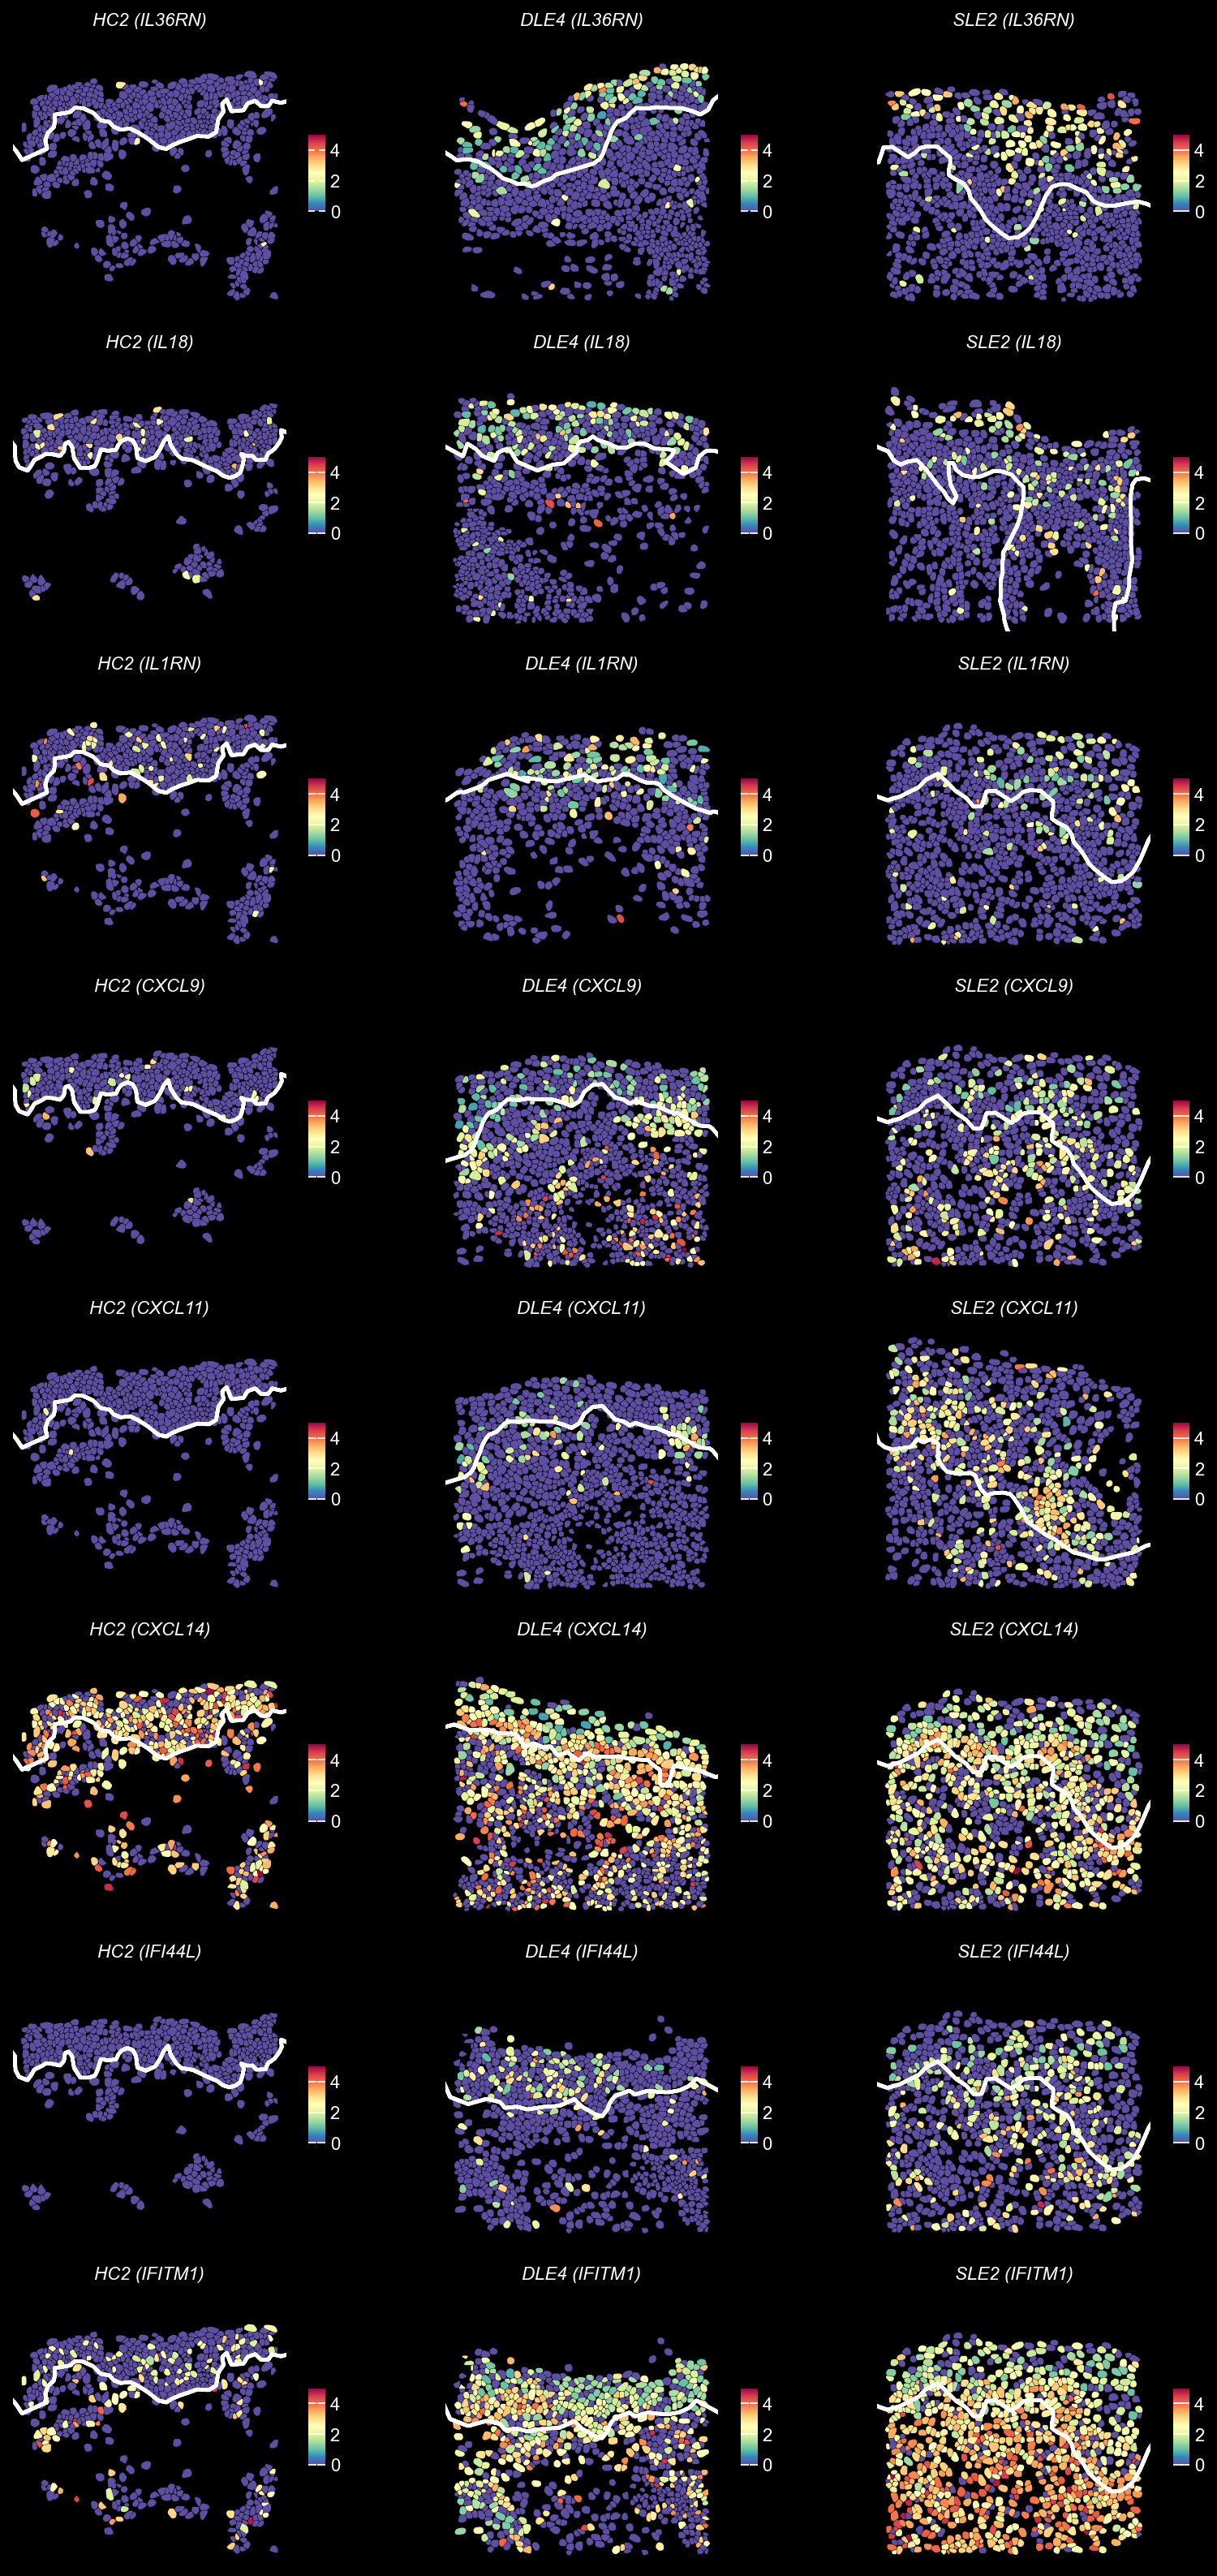

In [45]:
n_genes = len(genes_plot)
n_samples = len(samples)

with mpl.style.context('dark_background'):
    fig, axs = plt.subplots(
        nrows=n_genes,
        ncols=n_samples,
        figsize=(3.5 * n_samples, 2.5 * n_genes),
        squeeze=False
    )

    for i, gene in enumerate(genes_plot):   
        for j, sample in enumerate(samples):    
            ax = axs[i, j]
            BM_shp= gpd.read_file(f"/share/appspace_data/shared_groups/bgi_huangyf_project/Skin/Tissue_line/SHP_file//{sample}_BM_tussue_contour.shp")     
            sample_adata = ST_adata[ST_adata.obs["sample"] == sample]
            sample_zone = f"{sample}_{gene}" 
            zone_adata = within(sample_adata, zones[sample_zone], reduction='contour', inplace=True)
            ax = featureplot(zone_adata,features=gene,reduction="contour", ax=ax, style="dark_background", raster=False, vmax=5)
            BM_shp.plot(ax=ax, edgecolor='white',facecolor='none', linewidth=2)
            #draw_scalebar(ax=ax, color='white', location='lower left')
            sns.despine(ax=ax, right=False, top=False, left=False, bottom=False)
            ax.set_title(f"{sample} ({gene})", fontsize=10)  
            ax.set_xlim(zones[sample_zone][0]-30,zones[sample_zone][2]+30)
            ax.set_ylim(zones[sample_zone][1]-30,zones[sample_zone][3]+30)
            ax.axis("off")

    # plt.tight_layout(pad=1.0)
    # plt.show()
#save_fig(f"../../figures/Cellbin_KC_cytokine_gene_spatial_part_other")